In [4]:
import inspect
from typing import Any, Callable, Literal, Optional, Sequence, Type, Union, cast, get_args
from uuid import UUID, uuid5

from langchain_core.language_models import BaseChatModel, LanguageModelLike
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import BaseTool
from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt.chat_agent_executor import (
    AgentState,
    AgentStateWithStructuredResponse,
    Prompt,
    StateSchemaType,
    StructuredResponseSchema,
    _should_bind_tools,
    create_react_agent,
)
from langgraph.pregel import Pregel
from langgraph.pregel.remote import RemoteGraph
from langgraph.utils.config import patch_configurable
from langgraph.utils.runnable import RunnableCallable

from langgraph_supervisor.agent_name import AgentNameMode, with_agent_name
from langgraph_supervisor.handoff import (
    METADATA_KEY_HANDOFF_DESTINATION,
    _normalize_agent_name,
    create_handoff_back_messages,
    create_handoff_tool,
)
from dotenv import load_dotenv
load_dotenv()

True

In [13]:
from langchain_core.messages import convert_to_messages


def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

In [36]:
# Define dummy tools


def action_agent(query: str) -> str:

    """

    <use_case>

    This tool is capable of handling queries related to performing an action.

    Such as 

    1. add to outrearch sequence.

    2. remove from outreach sequence.

    3. add to marketo campaign.

    4. remove from marketo campaign.

    5. Export data.

    6. add these people as contacts in salesforce



    It also takes a JSON object (data) that can contain ids, type_of_ids (which can be 'account' or 'people'), or other relevant information.

    </use_case>

    <important_note>

    </important_note>

    """
    data = "nishant"

    print(f"Executing action_agent with query: '{query}', data: {data}")

    return {"action":"tool_one"}



def filter_agent(query: str) -> dict:

    """

    <use_case>

    This tool is capable of performing filtering operations based on the query.

    It first writes a query to the database and then returns the results.

    Example use cases include:

    1. filter accounts by highest engagement minutes, consider accounts with revenue equal or greater than $100 million

    2. show me accounts showing high intent

    3. please show me accounts that have filled out a form

    4. only show me leads of the executive leadership persona

    5. give me ubs account journey

    </use_case>

    <important_note>

    </important_note>

    """

    print(f"Executing tool_two with query: '{query}'")

    # Example dummy JSON response

    return {

        "results": [

            {"id": "acc_001", "name": "Account One", "engagement_minutes": 120, "revenue": 150_000_000},

            {"id": "acc_002", "name": "Account Two", "engagement_minutes": 95, "revenue": 110_000_000}

        ],

        "query": query

    }

In [37]:
from typing import Annotated
from langchain_core.tools import tool, InjectedToolCallId
from langgraph.prebuilt import InjectedState
from langgraph.graph import StateGraph, START, MessagesState
from langgraph.types import Command


def create_handoff_tool(*, agent_name: str, description: str | None = None):
    name = f"transfer_to_{agent_name}"
    description = description or f"Ask {agent_name} for help."

    @tool(name, description=description)
    def handoff_tool(
        state: Annotated[MessagesState, InjectedState],
        tool_call_id: Annotated[str, InjectedToolCallId],
    ) -> Command:
        tool_message = {
            "role": "tool",
            "content": f"Successfully transferred to {agent_name}",
            "name": name,
            "tool_call_id": tool_call_id,
        }
        return Command(
            goto=agent_name,  
            update={**state, "messages": state["messages"] + [tool_message]},  
            graph=Command.PARENT,  
        )

    return handoff_tool


# Handoffs
assign_to_research_agent = create_handoff_tool(
    agent_name="action_agent",
    description="Assign task to a action agent.",
)

assign_to_math_agent = create_handoff_tool(
    agent_name="filter_agent",
    description="Assign task to a filter agent.",
)

In [38]:
supervisor_agent = create_react_agent(
    model="openai:gpt-4.1",
    tools=[assign_to_research_agent, assign_to_math_agent],
    prompt=(
        "You are a supervisor managing two agents:\n"
        "- a action agent. Assign action-related tasks to this agent\n"
        "- a filter agent. Assign filter-related tasks to this agent\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."
    ),
    name="supervisor",
)

In [39]:
from langgraph.graph import END

# Define the multi-agent supervisor graph
supervisor = (
    StateGraph(MessagesState)
    # NOTE: `destinations` is only needed for visualization and doesn't affect runtime behavior
    .add_node(supervisor_agent, destinations=("action_agent", "filter_agent", END))
    .add_node(action_agent)
    .add_node(filter_agent)
    .add_edge(START, "supervisor")
    # always return back to the supervisor
    .add_edge("filter_agent", "supervisor")
    .add_edge("action_agent", "supervisor")
    .compile()
)

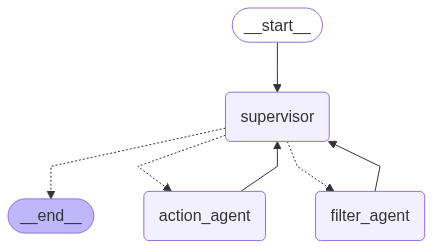

In [40]:
from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_mermaid_png()))

In [41]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "can you add to outreach sequence for id 1",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_action_agent

Successfully transferred to action_agent


Executing action_agent with query: '{'messages': [HumanMessage(content='can you add to outreach sequence for id 1', additional_kwargs={}, response_metadata={}, id='e8f887cb-72dd-467f-831a-73d9a1a1647b'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_4phL9VCrqpLLwRhTSpORsvdD', 'function': {'arguments': '{}', 'name': 'transfer_to_action_agent'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 124, 'total_tokens': 136, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_51e1070cf2', 'id': 'chatcmpl-BcNe

TypeError: 'NoneType' object is not subscriptable

In [ ]:
# Install globally
npm install -g openapi-to-mcp

# Or use directly with npx
npx openapi-to-mcp <swagger-file>